# Модели бинарного выбора

**Предмет исследования:** модель «бинарного выбора» для прогнозирования факта использования клиентом выдаваемого банком кредита с целью составления максимально оптимизированной клиентской базы. 

**Объект исследования:** данные о 5000 клиентах банка, включающие в себя демографическую информация, взаимоотношения клиента с банком и решение клиента о займе в предыдущей банковской компании. 

### Описание признаков
`ID` - Идентификатор клиента  
`Age` - Возраст  
`Experience` - профессиональный опыт(лет)  
`Income` - годовой доход клиента(тыс \\$)  
`ZIPCode` - индекс домашего адреса  
`Family` - размер семьи клиента  
`CCAvg` - средние расходы по кредитным картам(тыс \\$)  
`Education` - уровень образования: 1-студент, 2-выпускник, 3-продвинутый/профессионал  
`Mortgage` - стоимость ипотеки дома(тыс \\$)  
`Personal Loan` - Принимал ли этот клиент личный кредит, предложенный в последней кампании?  
`Securities Account` - Есть ли у клиента счет в ценных бумагах в банке?  
`CD Account` - Есть ли у клиента депозитный счет в банке?  
`Online` - Использует ли клиент услуги интернет-банкинга?  
`CreditCard` - Использует ли клиент кредитную карту банка?

## Загрузка и изучение датасета

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import f
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score,\
recall_score, f1_score, r2_score, roc_auc_score, roc_curve, silhouette_score
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from statsmodels.discrete.discrete_model import Probit
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('Bank_Personal_Loan_Modelling.csv')

In [3]:
data.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
ID                    5000 non-null int64
Age                   5000 non-null int64
Experience            5000 non-null int64
Income                5000 non-null int64
ZIP Code              5000 non-null int64
Family                5000 non-null int64
CCAvg                 5000 non-null float64
Education             5000 non-null int64
Mortgage              5000 non-null int64
Personal Loan         5000 non-null int64
Securities Account    5000 non-null int64
CD Account            5000 non-null int64
Online                5000 non-null int64
CreditCard            5000 non-null int64
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [5]:
data = data.drop(['ID','ZIP Code'], axis = 1)

In [6]:
data.duplicated().sum()

13

In [7]:
data = data.drop_duplicates()

Данные полные, отсутствуют пропуски, типы данных колонок соответствуют фактическим. Принимаем решения удалить явно не влияющие на результат признаки: идентификатор клиента(ID) и индекс адреса(ZIP code). Имеем 5 бинарных признаков, 4 числовых и 2 категориальных. Найдено 13 дубликатов, принято решение удалить их.

## Анализ данных

Изучим структуру датасета, соотношение меток целевой переменной.

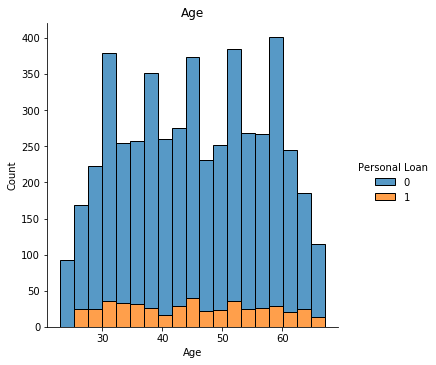

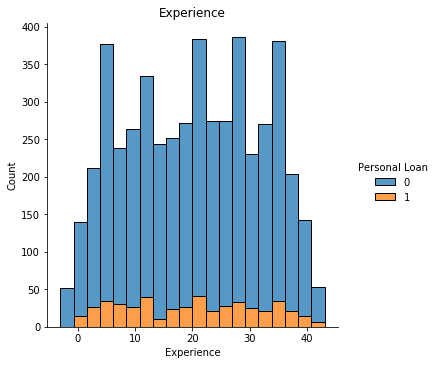

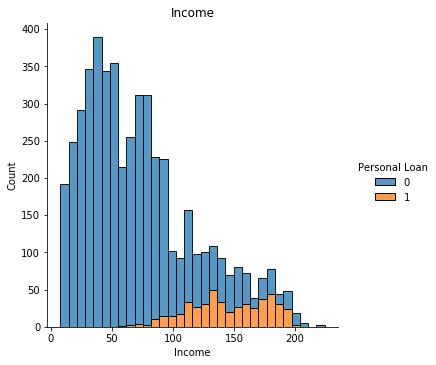

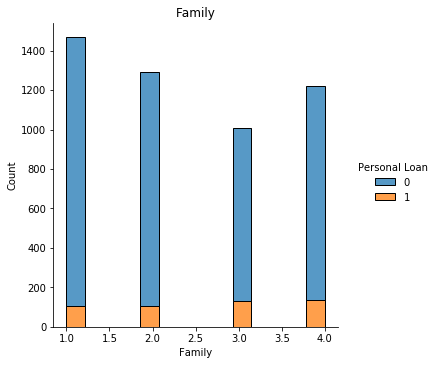

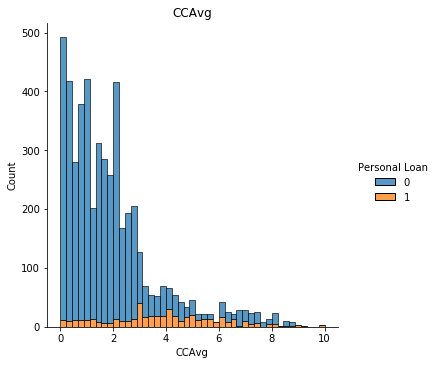

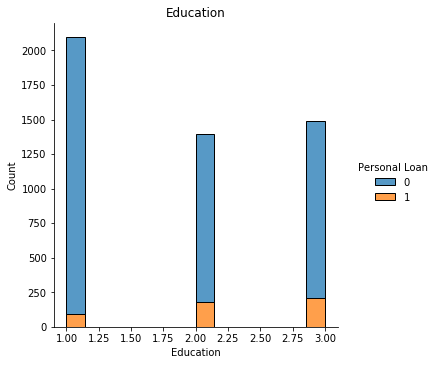

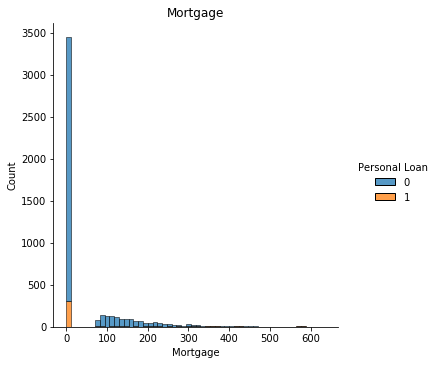

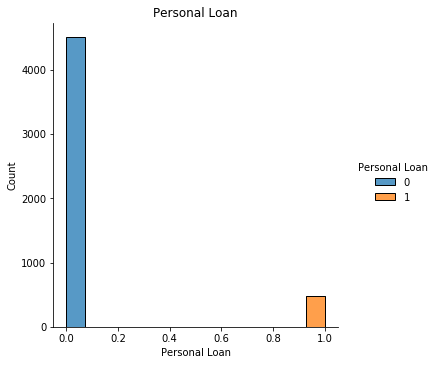

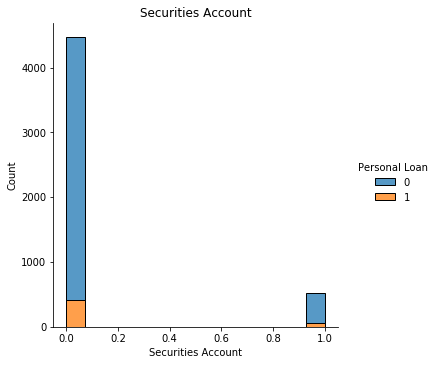

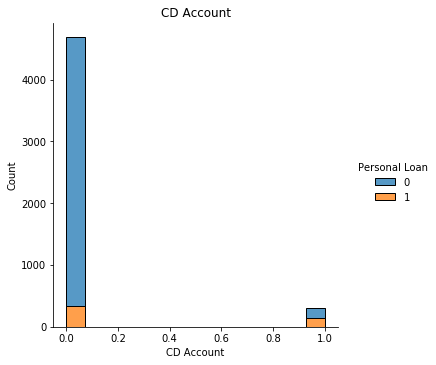

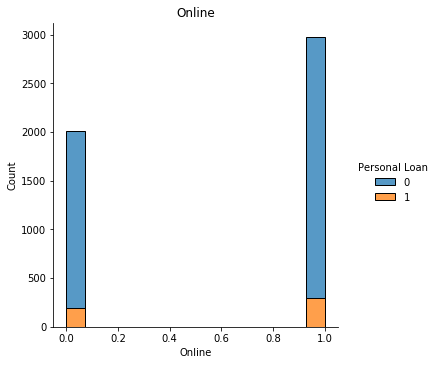

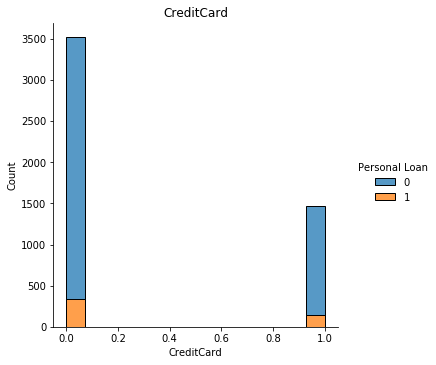

In [8]:
for column in data.columns:
    sns.displot(data = data, x = column, hue = 'Personal Loan', multiple="stack")
    plt.title(column)
    plt.show()

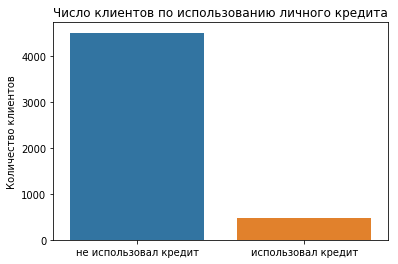

In [9]:
sns.countplot(x='Personal Loan', data = data)
plt.title('Число клиентов по использованию личного кредита')
plt.ylabel('Количество клиентов')
plt.xlabel('')
plt.xticks(np.arange(2), ('не использовал кредит', 'использовал кредит'))
plt.show()

Посмотрим на зависимость между годовым доходом клиента и факта использования кредита.

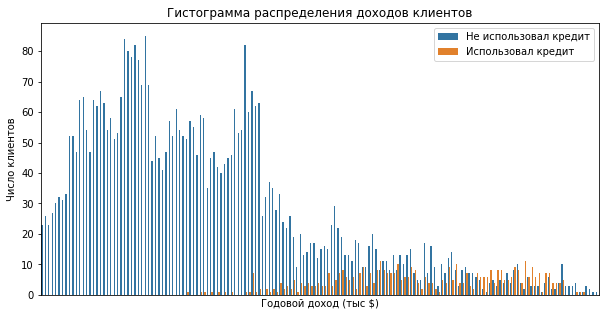

In [10]:
plt.figure(figsize=(10, 5))
sns.countplot(x='Income', hue = 'Personal Loan', data = data)
plt.title('Гистограмма распределения доходов клиентов')
plt.xlabel('Годовой доход (тыс $)')
plt.ylabel('Число клиентов')
plt.legend(['Не использовал кредит', 'Использовал кредит'], loc="upper right")
plt.xticks(np.arange(0),'')
plt.show()

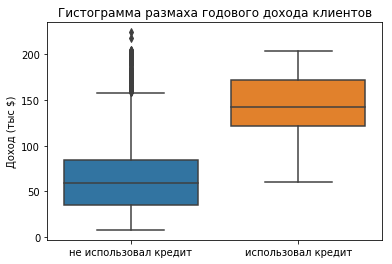

In [11]:
sns.boxplot(x='Personal Loan', y='Income', data=data)
plt.title('Гистограмма размаха годового дохода клиентов')
plt.ylabel('Доход (тыс $)')
plt.xlabel('')

plt.xticks(np.arange(2), ('не использовал кредит', 'использовал кредит'))
plt.show()

Посмотрим распределение признака професииональный опыт.

In [12]:
data['Experience'].describe()

count    4987.000000
mean       20.114498
std        11.464902
min        -3.000000
25%        10.000000
50%        20.000000
75%        30.000000
max        43.000000
Name: Experience, dtype: float64

Максимальное значение 43, возможно, медиана распределения 20 лет, минимальное значение отрицательно, удалим записи с таким значением.

In [13]:
data = data.query('Experience>=0')

Посмотрим соотношение средней стоимости ипотеки дома по факту использования кредита.

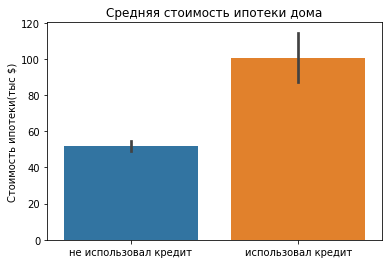

In [14]:
sns.barplot(y='Mortgage', x = 'Personal Loan', data = data)
plt.title('Средняя стоимость ипотеки дома')
plt.ylabel('Стоимость ипотеки(тыс $)')
plt.xlabel('')
plt.xticks(np.arange(2), ('не использовал кредит', 'использовал кредит'))
plt.show()

In [15]:
data.corr()['Personal Loan']

Age                  -0.014517
Experience           -0.014454
Income                0.504278
Family                0.063125
CCAvg                 0.369167
Education             0.139255
Mortgage              0.141920
Personal Loan         1.000000
Securities Account    0.021928
CD Account            0.315621
Online                0.006622
CreditCard            0.002366
Name: Personal Loan, dtype: float64

Коэффициент корреляции показывает линейную связь между результатом и годовым доходом(Income) и наличием депозитного счета(CD Account). Наименьшая связь с признаками использования онлайн банкинга(Online), использованием конкретной кредитной карты(CreditCard), возрастом(age) и опытом(Experience). Построим тепловую карту признаков.

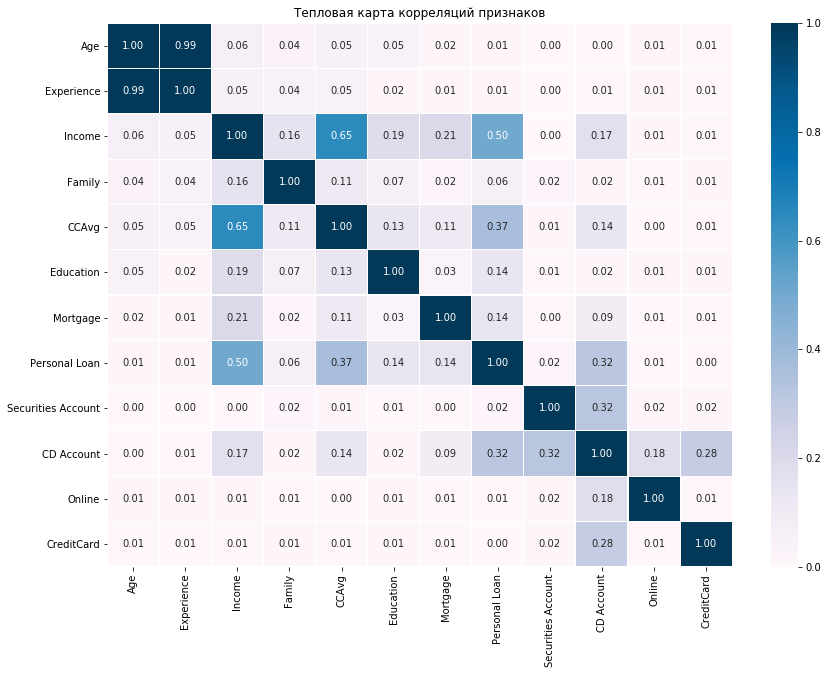

In [16]:
plt.figure(figsize=(14, 10))
sns.heatmap(data.corr().abs(), annot = True, fmt = '0.2f', linewidths=.1,cmap="PuBu", vmin=0,)
plt.title('Тепловая карта корреляций признаков')
plt.show()

Видим сильную линейную связь между возрастом и опытом, построим точечную диаграмму.

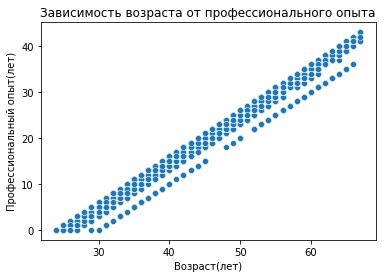

In [17]:
sns.scatterplot(x = 'Age', y = 'Experience', data = data)
plt.title('Зависимость возраста от профессионального опыта')
plt.ylabel('Профессиональный опыт(лет)')
plt.xlabel('Возраст(лет)')
plt.show()

Удалим колонку Age, чтобы не дублировать признаки.

In [18]:
data = data.drop(['Age'], axis = 1)

Меток использования кредита в целевой переменной значительно больше, учтем это при проверке метрик качества. Исследовали зависимость между годовым доходом клиента и фактом использования кредита, медиана дохода использовавших кредит в два раза превышает медианное не использовавших. Медана стоимости ипотеки дома использовавших кредит выше.

Мы изучили матрицу корреляций. Коэффициент корреляции показывает линейную связь между результатом и годовым доходом(Income) и наличием депозитного счета(CD Account). Наименьшая связь с признаками использования онлайн банкинга(Online), использованием конкретной кредитной карты(CreditCard), возрастом(age) и опытом(Experience).
Между возрастом и опытом прямаяя линейная связь, принято решение удалить колонку возраста. Также датаст был очищен от выбросов - отрицательных значений параметра опыт.

## Обучение моделей

Построим модель логистической регрессии, выделим признаки и результат, поделим датасет на тестовую и валидационную выборку.

In [19]:
y = data['Personal Loan']
X = data.drop('Personal Loan', axis = 1)
sc = StandardScaler()
X = sc.fit_transform(X)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=0)

In [21]:
model = LogisticRegression() 
model.fit(X_train, y_train)
logit_predict = model.predict(X_test)
logit_probabilities = model.predict_proba(X_test)[:,1]

In [22]:
print(logit_predict[25:35])
print(logit_probabilities[25:35])

[0 0 0 0 0 1 0 0 0 0]
[7.76095409e-04 3.09314517e-04 1.75483244e-04 7.16943607e-04
 6.47567910e-04 6.58377840e-01 1.25471291e-02 1.27555322e-03
 5.00208028e-02 2.64495553e-02]


In [23]:
#выведем коэффициенты модели
model.coef_

array([[ 0.04078695,  2.35531066,  0.75205026,  0.21299655,  1.39291392,
         0.028992  , -0.26856213,  0.89746766, -0.32190603, -0.45642042]])

In [24]:
def metrics(y_test, predictions):
    """Функция выводит метрики качества предсказаний

    Аргументы:
    y_test -- истинные значения personal load
    predictions -- предсказанные моделью значения
    """
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score (y_test, predictions)))
    print('Recall: {:.2f}'.format(recall_score (y_test, predictions)))
    print('F1: {:.2f}'.format(f1_score(y_test, predictions)))


In [25]:
metrics(y_test, logit_predict)

Accuracy: 0.96
Precision: 0.90
Recall: 0.65
F1: 0.75


Построим кривую ошибок

In [26]:
def roc(y_test, predict, probabilities, type):
    global roc_auc
    roc_auc = roc_auc_score(y_test, predict)
    fpr, tpr, thresholds = roc_curve(y_test, probabilities)
    plt.figure()
    plt.plot(fpr, tpr, label='{} Regression (area = {:0.2f})'.format(type,roc_auc))
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.01])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Кривая ошибок(ROC)')
    plt.legend(loc="lower right")
    plt.show()

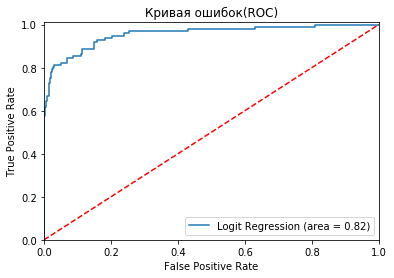

In [27]:
roc(y_test, logit_predict, logit_probabilities, 'Logit')

In [28]:
roc_auc

0.8189884960718296

Построим probit регресиию по тому же разбиению

In [29]:
X_train = sm.add_constant(X_train)
model = Probit(y_train, X_train.astype(float))
probit_model = model.fit()
print(probit_model.summary2())

Optimization terminated successfully.
         Current function value: 0.131964
         Iterations 8
                         Results: Probit
Model:              Probit           Pseudo R-squared: 0.586      
Dependent Variable: Personal Loan    AIC:              1063.9902  
Date:               2021-04-30 19:36 BIC:              1133.0809  
No. Observations:   3948             Log-Likelihood:   -521.00    
Df Model:           10               LL-Null:          -1259.5    
Df Residuals:       3937             LLR p-value:      2.2548e-311
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     8.0000                                        
--------------------------------------------------------------------
           Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
--------------------------------------------------------------------
const     -2.4571     0.0821   -29.9443   0.0000   -2.6179   -2.2962
x1         0.0030     0.0431     0.0696   0.9

p значение признаков профессиональны опыт(Experience) и стоимости ипотеки дома (Mortgage) превышают уровень значимости 0.05. Принимаем решение исключить их для повышения качества модели. Построим заново регресии и проверим метрики качества.

In [30]:
data_significant = data.drop(['Experience','Mortgage'], axis = 1)

In [31]:
y = data_significant['Personal Loan']
X = data_significant.drop('Personal Loan', axis = 1)
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
model =  LogisticRegression() 
model.fit(X_train, y_train)
logit_predict = model.predict(X_test)
logit_probabilities = model.predict_proba(X_test)[:,1]

In [32]:
metrics(y_test, logit_predict)

Accuracy: 0.96
Precision: 0.83
Recall: 0.67
F1: 0.74


In [33]:
roc_auc_score(y_test, logit_predict)

0.8305500348450041

In [34]:
X_train = sm.add_constant(X_train)
model = Probit(y_train, X_train.astype(float))
probit_model = model.fit()
print(probit_model.summary2())

Optimization terminated successfully.
         Current function value: 0.135008
         Iterations 8
                        Results: Probit
Model:              Probit           Pseudo R-squared: 0.584    
Dependent Variable: Personal Loan    AIC:              1084.0207
Date:               2021-04-30 19:36 BIC:              1140.5494
No. Observations:   3948             Log-Likelihood:   -533.01  
Df Model:           8                LL-Null:          -1281.7  
Df Residuals:       3939             LLR p-value:      0.0000   
Converged:          1.0000           Scale:            1.0000   
No. Iterations:     8.0000                                      
------------------------------------------------------------------
         Coef.    Std.Err.      z       P>|z|     [0.025    0.975]
------------------------------------------------------------------
const   -2.4099     0.0792   -30.4436   0.0000   -2.5650   -2.2547
x1       1.2835     0.0640    20.0657   0.0000    1.1581    1.4088
x2 

In [35]:
X_test = sm.add_constant(X_test)
probit_predict = probit_model.predict(X_test.astype(float))
predicted_choice = (probit_predict > 0.5).astype(int)

In [36]:
metrics(y_test, predicted_choice)

Accuracy: 0.96
Precision: 0.83
Recall: 0.66
F1: 0.74


In [37]:
roc_auc_score(y_test, predicted_choice)

0.8247360813566321

Наиболее успешная модель - probit-регрессия. Подберем границу классов, чтобы увеличить точность.

In [38]:
predicted_choice = (probit_predict > 0.3).astype(int)

In [39]:
metrics(y_test, predicted_choice)
print('псевдо R^2: {:.2f}'.format(probit_model.prsquared))

Accuracy: 0.95
Precision: 0.67
Recall: 0.84
F1: 0.75
псевдо R^2: 0.58


In [40]:
probit_roc_auc = roc_auc_score(y_test, predicted_choice)
probit_roc_auc

0.8991817876777741

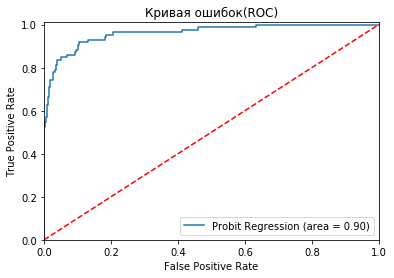

In [41]:
roc(y_test, predicted_choice, probit_predict, 'Probit')

In [42]:
probit_model.params

const   -2.409881
x1       1.283451
x2       0.418536
x3       0.107053
x4       0.681900
x5      -0.153900
x6       0.483891
x7      -0.182755
x8      -0.274954
dtype: float64

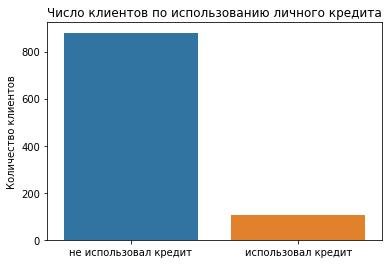

In [43]:
sns.countplot(x='Personal Loan', data = pd.DataFrame(data = pd.DataFrame(data = predicted_choice,
                                                                         columns = ['Personal Loan'])))
plt.title('Число клиентов по использованию личного кредита')
plt.ylabel('Количество клиентов')
plt.xlabel('')
plt.xticks(np.arange(2), ('не использовал кредит', 'использовал кредит'))
plt.show()

Мы построили модели logit и probit регресии, оценили качество при помощи различных метрик. По результатам оценки параметров исключили два фактора: профессиональны опыт(Experience) и стоимости ипотеки дома (Mortgage). По результатам оценки метрик наиболее удачной для конкретной задачи выбрана модель probit-регресии, мы подобрали границу разделения классов 0.3, в таком виде значения метрик качества Accuracy 0.95, precision 0.67, recall 0.84, F мера 0.75, ROC-AUC 0.9.

## Кластеризация клиентов

Выделим кластеры и посмотрим на их особенности

In [44]:
linked = linkage(X, method = 'ward')

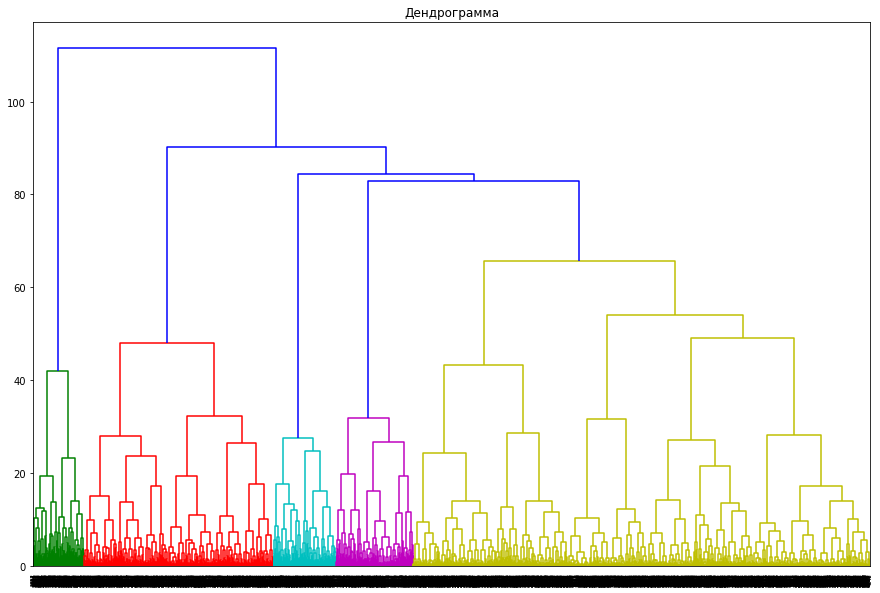

In [45]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Дендрограмма')
plt.show()

In [46]:
km = KMeans(n_clusters = 5, random_state = 0)
labels = km.fit_predict(X) 

In [47]:
data['cluster'] = labels
data.cluster.value_counts()

3    2382
1    1034
0     855
4     362
2     302
Name: cluster, dtype: int64

In [48]:
discrete = ['Education', 'Securities Account', 'CD Account', 'Online',
       'CreditCard']
continuous = ['Experience', 'Income', 'Family', 'CCAvg', 'Mortgage']

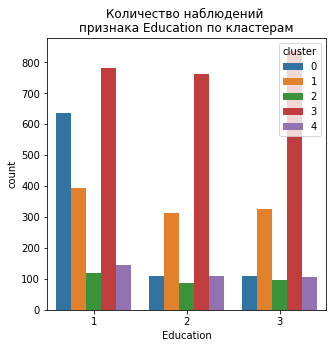

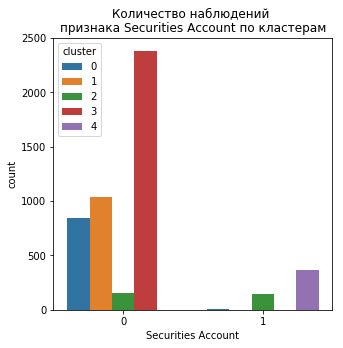

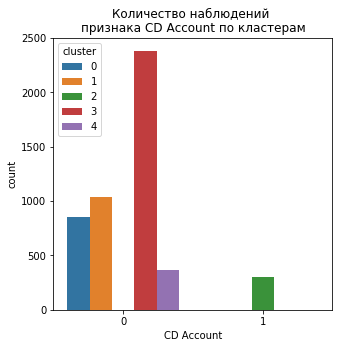

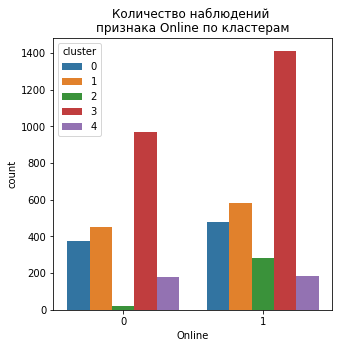

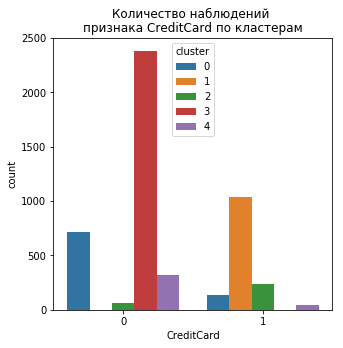

In [49]:
for column in discrete:
    plt.figure(figsize=(5, 5))
    sns.countplot(x = column, hue='cluster', data=data)
    plt.title('Количество наблюдений \nпризнака {} по кластерам'.format(column))
    plt.show()

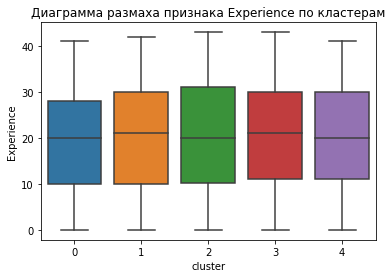

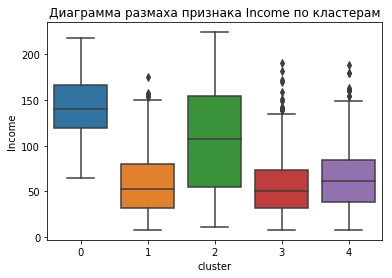

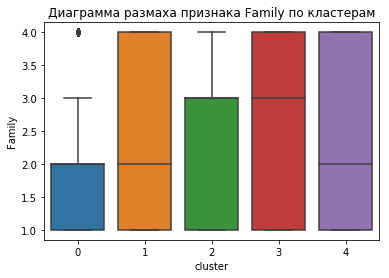

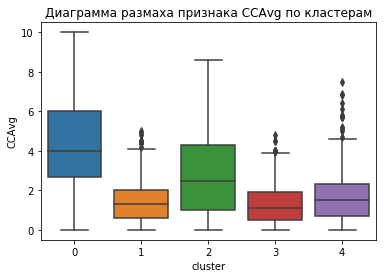

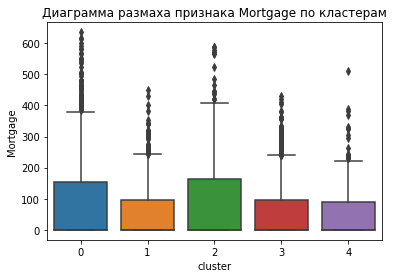

In [50]:
for column in continuous:
    sns.boxplot(x = 'cluster', y = column, data = data)
    plt.title('Диаграмма размаха признака {} по кластерам'.format(column))
    plt.show()

In [51]:
data.groupby('cluster').mean().T

cluster,0,1,2,3,4
Experience,19.678363,20.500000,20.572848,20.518892,20.096685
Income,140.857310,57.581238,104.589404,54.379933,64.737569
Family,1.789474,2.500000,2.460265,2.532746,2.519337
CCAvg,4.230538,1.364797,2.878974,1.282909,1.694862
Education,1.381287,1.933269,1.927152,2.022670,1.889503
Mortgage,86.784795,47.259188,92.324503,47.108312,47.143646
Personal Loan,0.277193,0.028046,0.463576,0.027288,0.024862
Securities Account,0.008187,0.000000,0.486755,0.000000,1.000000
CD Account,0.000000,0.000000,1.000000,0.000000,0.000000
Online,0.561404,0.565764,0.937086,0.592779,0.505525


Видим, что клиенты, использующие кредит отнесны к кластерам 0 и 2, их отличает: высокий годовой доход, высокий уровень расходов по кредитным картам, высокая стоимость ипотеки дома, использование(кластер 2) и не использование депозитного счета(кластер 0), использование кредитной карты Union банка(кластер 2).

Кластеры клиентов, не использующие кредит характеризуются, кластер 1 и 3 - не использовани депохитов и инвестиционных счетов, кл 1 - использование кредитной карты union банка, не использование (кластер 3). Кластер 4 - больщой размер семьи, в среднем больше 2,5, использование инвест счета и не использование депозита.

## Вывод
Мы загрузили датасет и исследовали его структуру. Меток использования кредита в целевой переменной значительно больше, учтем это при проверке метрик качества. Исследовали зависимость между годовым доходом клиента и фактом использования кредита, медиана дохода использовавших кредит в два раза превышает медианное не использовавших. Медана стоимости ипотеки дома использовавших кредит выше.

Мы изучили матрицу корреляций. Коэффициент корреляции показывает линейную связь между результатом и годовым доходом(Income) и наличием депозитного счета(CD Account). Наименьшая связь с признаками использования онлайн банкинга(Online), использованием конкретной кредитной карты(CreditCard), возрастом(age) и опытом(Experience).
Между возрастом и опытом прямаяя линейная связь, принято решение удалить колонку возраста. Также датаст был очищен от выбросов - отрицательных значений параметра опыт.

Мы построили модели logit и probit регресии, оценили качество при помощи различных метрик. По результатам оценки параметров исключили два фактора: профессиональны опыт(Experience) и стоимости ипотеки дома (Mortgage). По результатам оценки метрик наиболее удачной для конкретной задачи выбрана модель probit-регресии, мы подобрали границу разделения классов 0.3, в таком виде значения метрик качества Accuracy 0.95, precision 0.67, recall 0.84, F мера 0.75, ROC-AUC 0.9.

Заметили, что клиенты, использующие кредит отнесены к кластерам 0 и 2, их отличает: высокий годовой доход, высокий уровень расходов по кредитным картам, высокая стоимость ипотеки дома, использование(кластер 2) и не использование депозитного счета(кластер 0), использование кредитной карты Union банка(кластер 2).

Кластеры клиентов, не использующие кредит характеризуются, кластер 1 и 3 - не использовани депозитов и инвестиционных счетов, кл 1 - использование кредитной карты union банка, не использование (кластер 3). Кластер 4 - больщой размер семьи, в среднем больше 2,5, использование инвест счета и не использование депозита.